In [289]:
import pandas as pd
from heatmap import heatmap, corrplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [290]:
features = pd.read_csv("winequality-red.csv")
#features["quality"] = features["quality"].apply(float) # Changing the problem from classification to linear regression
features.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## NAN Check

In [291]:
features.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Remove if there are any

In [292]:
features = features.dropna()

In [293]:
features.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Shows the true quality range

<Axes: xlabel='quality'>

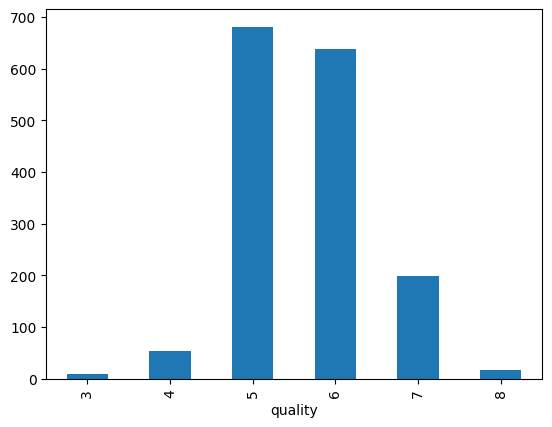

In [294]:
features.groupby('quality')['quality'].agg('count').plot.bar()

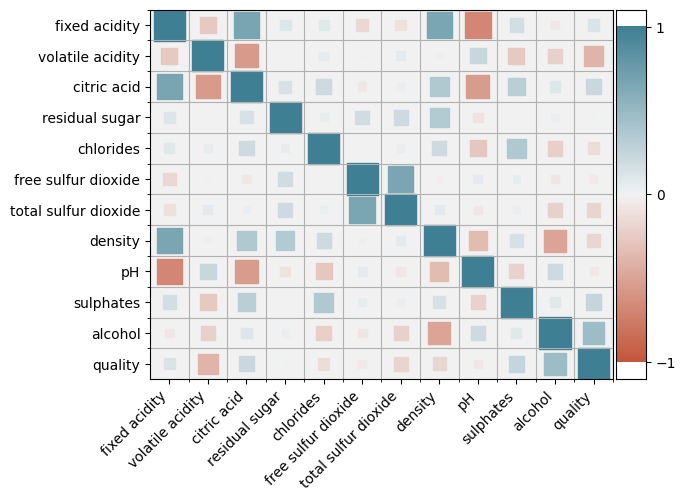

In [295]:
corrplot(features.corr())

## Outlier Detection

<Axes: >

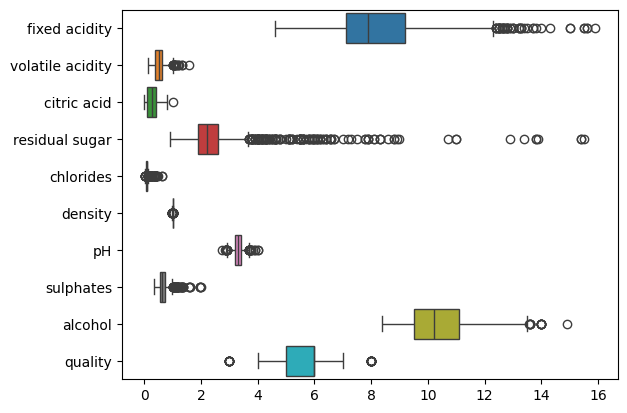

In [296]:
selective = features.copy()
selective = selective.drop(["free sulfur dioxide", "total sulfur dioxide"], axis = 1 )

sns.boxplot(data=selective, orient="h", native_scale=False)

<Axes: >

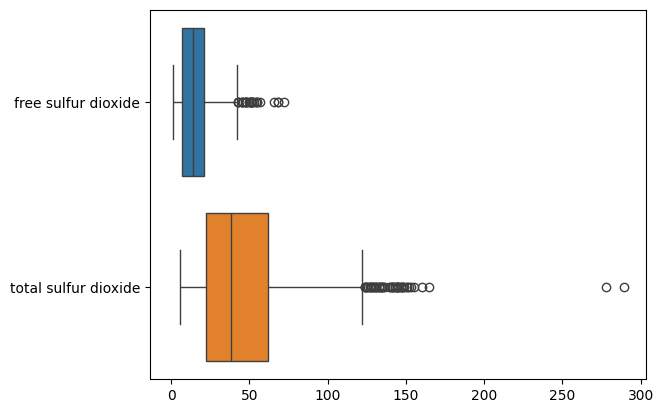

In [297]:
sns.boxplot(data=features[["free sulfur dioxide", "total sulfur dioxide"]], orient="h", native_scale=False)

### Outlier Removal

In [298]:
features_filtered = features[(np.abs(stats.zscore(features)) < 3).all(axis=1)]

print("Old Dataset: ", features.shape)
print("New Dataset: ", features_filtered.shape)
print("Removed",features.shape[0] - features_filtered.shape[0] ,"rows")

Old Dataset:  (1599, 12)
New Dataset:  (1451, 12)
Removed 148 rows


In [299]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [round(variance_inflation_factor(X.values, i), 2) for i in range(X.shape[1])]

    return(vif)

vif_df = add_constant(features_filtered.copy())

VIF = calc_vif(vif_df)
VIF = VIF[~(VIF["variables"] == "const")]
VIF

,variables,VIF
1,fixed acidity,7.95
2,volatile acidity,1.91
3,citric acid,3.20
4,residual sugar,1.65
5,chlorides,1.17
6,free sulfur dioxide,1.94
7,total sulfur dioxide,2.21
8,density,6.42
9,pH,3.23
10,sulphates,1.40


In [300]:
vif_df = add_constant(features_filtered.copy().drop(["density", "fixed acidity"], axis=1))
VIF = calc_vif(vif_df)
VIF = VIF[~(VIF["variables"] == "const")]
VIF

,variables,VIF
1,volatile acidity,1.80
2,citric acid,2.26
3,residual sugar,1.14
4,chlorides,1.12
5,free sulfur dioxide,1.92
6,total sulfur dioxide,2.09
7,pH,1.54
8,sulphates,1.31
9,alcohol,1.60
10,quality,1.61


In [301]:
features_filtered = features_filtered.drop(["density", "fixed acidity"], axis=1)

In [302]:
y = features_filtered["quality"]
X = features_filtered.drop("quality", axis=1)

In [327]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=1)

In [328]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(criterion="log_loss")
rf_clf.fit(X_train, Y_train)
rf_clf.score(X_test, Y_test)

0.711340206185567

In [305]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
def optimal_model(X,y):

    models = {
        "Logistic Regression": {
            'model': LogisticRegression(),
            'parameters':{'fit_intercept':[True,False], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'class_weight':[None,'balanced']}
        },

        "Naive Bayes": {
            'model': MultinomialNB(),
            'parameters':{}
        
        },
        
        "Random Forest Classifier": {
            'model':RandomForestClassifier(),
            'parameters':{'criterion':["gini", "entropy", "log_loss"]}

        }
    }
    

    scores = []
    cv = ShuffleSplit(test_size=0.2)
    for name, config in models.items():
        model , parameters = config['model'], config['parameters']
        clf = GridSearchCV(model, parameters, cv=cv, return_train_score=False)
        clf.fit(X,y)
        scores.append({
            'model': name,
            'best_score': clf.best_score_,
            'best_params':clf.best_params_
        })
    return pd.DataFrame(scores,columns=['model', 'best_score', 'best_params'])

In [306]:
search = optimal_model(X_train, Y_train)

search

c:\Users\joshu\anaconda3\envs\Car\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\joshu\anaconda3\envs\Car\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

,model,best_score,best_params
0,Logistic Regression,0.604310,"{'class_weight': None, 'fit_intercept': True, ..."
1,Naive Bayes,0.462931,{}
2,Random Forest Classifier,0.699138,{'criterion': 'entropy'}


In [307]:
def predict_quality(*inputs):
    return rf_clf.predict([np.array(inputs)])[0]

predict_quality(0.70,0.00,1.9,0.076,11.0,34.0,3.51,0.56,9.4)

c:\Users\joshu\anaconda3\envs\Car\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


5

In [329]:
import pickle

with open('wine_quality_model.pickle', 'wb') as f:
    pickle.dump(rf_clf,f)

In [330]:
import json

columns = {
    'data_columns': [col.lower() for col in X.columns]
}

with open("columns.json", "w") as f:
    f.write(json.dumps(columns))